In [1]:
import os
import pandas as pd
import numpy as np
import re
# These functions are needed to check dtypes and convert if necessary
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [2]:
# A dictionary of sheet description to better remember the purpose of each sheet.
sheets_desc = {"Data": "مشخصات پرسشنامه",
               "P1":"قسمت یکم: خصوصیات اجتماعی اعضای خانوار",
               "P2": "قسمت دوم: مشخصات محل سکونت",
               "P3S01": "قسمت سوم: بخش ۱ هزینه‌های خوراکی خانوار در ماه گذشته",
               "P3S02": "قسمت سوم: بخش ۲ هزینه‌های نوشیدنی‌های طبقه‌بندی نشده و دخانی های خانوار در ماه گذشته",
               "P3S03": "قسمت سوم: بخش ۳ هزینه‌های پوشاک و کفش خانوار در ماه گذشته",
               "P3S04": "قسمت سوم: بخش ۴ هزینه‌های بخش مسکن، آب، فاضلاب، سوخت و روشنایی خانوار در ماه گذشته",
               "P3S05": "قسمت سوم: بخش ۵ هزینه‌های مبلمان و لوازم خانگی",
               "P3S06": "قسمت سوم: بخش ۶ هزینه‌های بهداشتی و درمانی خانوار در ماه گذشته",
               "P3S07": "قسمت سوم: بخش ۷ هزینه‌های حمل و نقل خانوار در ماه گذشته",
               "P3S08": "قسمت سوم: بخش ۸ هزینه‌های ارتباطات خانوار در ماه گذشته",
               "P3S09": "قسمت سوم: بخش ۹ هزینه‌های خدمات فرهنگی و تفریحات خانوار در ماه گذشته",
               "P3S10": "قسمت سوم: بخش ۱۰ هزینه‌های آموزش و تحصیل",  # empty sheet, included in P3S13
               "P3S11": "قسمت سوم: بخش ۱۱ هزینه‌های غذاهای آماده، هتل و رستوران خانوار در ماه گذشته",
               "P3S12": "قسمت سوم: بخش ۱۲ هزینه‌های کالاها و خدمات متفرقه خانوار در ماه گذشته",
               "P3S13": "قسمت سوم: بخش ۱۳ سایر هزینه‌ها و انتقالات در ۱۲ ماه گذشته",
               "P3S14": "قسمت سوم: بخش ۱۴ سرمایه‌گذاری خانوار در ۱۲ ماه گذشته",
               "P4S01": "قسمت چهارم: بخش ۱ درآمد پولی اعضای شاغل خانوار از مشاغل مزد و حقوق بگیری",
               "P4S02": "قسمت چهارم: بخش ۲ درآمد پولی اعضای شاغل خانوار از مشاغل غیر مزد و حقوق بگیری (آزاد)",
               "P4S03": "قسمت چهارم: بخش ۳ درآمدهای متفرقه خانوار در ۱۲ ماه گذشته",
               "P4S04": "قسمت چهارم: ستون ۹ بخش ۳ شامل وام و یارانه"
               }

In [3]:
#Desired info:
sheet_indices = [0,1,2,9,13, 15, 17,18,19,20]

In [4]:
resource_directory = "G:\\ai\\project 1\\dataset"
resource_files : list[str] = []
for f in os.listdir(resource_directory):
    f_path = os.path.join(resource_directory, f)
    if os.path.isfile(f_path):
        resource_files.append(f)
del f, f_path

In [5]:
def empty_string_remover(df):
    for col in df.columns:
    # Checking if string dtype
        if is_string_dtype(df[col]):
            # replace cells with only empty strings with np.nan
            df[col] = df[col].replace(r'^\s*$', np.nan, regex=True)
    return df

In [6]:
dfs = []

for filename in resource_files:

    file_path = os.path.join(resource_directory, filename)
    year_file = pd.ExcelFile(file_path, engine='openpyxl')

    if filename.startswith("U"):
        Urban = True
    else:
        Urban = False

    year = int(filename.strip(".xlsx")[1:])
    if (year==99) or (year ==98):
        year = 1300+year

    for sheet_index in sheet_indices:

        sheet_name = list(sheets_desc.keys())[sheet_index]
        print(f"Sheet name from sheets_desc dict: {sheet_name}.",
            f"Sheet name from file: {year_file.sheet_names[sheet_index]}\n",
            f"Loaded sheet description: {sheets_desc[sheet_name]}")

        if sheet_index==0:
            current_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            current_df = empty_string_remover(current_df)
            # Here we add year and Urban columns to the Data (first sheet) dataframe
            current_df["Urban"] = Urban
            current_df["Year"] = year

            # Drop rows that:
                # TakmilDescA is not being nan, these only exist in year 1401.
                # TakmilDescB or JaygozinDescA or JaygozinDescB or JaygozinDescC is not nan,
                # Jaygozin ==2,
                # However, JaygozinDescC does not appear to have a specific definition.
                # Because all the above mean the end of survey for that family.

            current_df = current_df.loc[current_df.TakmilDescA.isna() |
                                    current_df.TakmilDescB.isna() |
                                    current_df.JaygozinDescA.isna() |
                                    current_df.JaygozinDescB.isna() |
                                    current_df.Jaygozin!=2, :]
            if "JaygozinDescC" in current_df.columns:
                current_df = current_df.loc[current_df.JaygozinDescC.isna(), :]

            # We only consider addresses from this dataframe and do left join with other dfs
            year_df = current_df.loc[:, ["Address", "Fasl", "Urban", "Year", "khanevartype", "province", "town"]].copy()
            del current_df

        if sheet_index==1:
            current_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            current_df = empty_string_remover(current_df)
            # Counting family members of each family
            family_member_count = (current_df.groupby("Address")
                                .agg({"member": "count"})
                                .rename(columns={"member": "member_cnt"}).reset_index())

            # Counting employed or student members of a family,
            # presumably because the go outside more and have more transportation expense
            active_member_count = (current_df.loc[current_df.occupationalst.str.lower().isin(["employed", "student"]),
                                                    ["Address", "occupationalst"]]
                                            .groupby("Address").agg({"occupationalst": "count"})
                                            .rename(columns={"occupationalst": "active_member_cnt"})
                                            .reset_index())
            family_mean_age = (current_df.groupby("Address").agg({"age": "mean"})
                                .rename(columns={"age": "mean_age"})
                                .reset_index())





            # Counting members with more than Diploma education
            # Maybe these people go out more often
            highly_educated_members_count = (current_df.loc[current_df.degree
                                                            .isin(['Bachelor', 'College', 'Master', 'PhD']),
                                                            ["Address", "degree"]]
                                            .groupby("Address").agg({"degree": "count"})
                                            .rename(columns={"degree": "highly_educated_member_cnt"})
                                            .reset_index())

            year_df = pd.merge(year_df, family_member_count, how="left", on="Address")
            year_df = pd.merge(year_df, active_member_count, how="left", on="Address")
            year_df = pd.merge(year_df, family_mean_age, how="left", on="Address")
            year_df = pd.merge(year_df, highly_educated_members_count, how="left", on="Address")
            del current_df, family_member_count, active_member_count, family_mean_age, highly_educated_members_count


        # Maybe if they have vehicles, they spend less on public transportation cost
        # However, they might spend more on personal vehicle expenses
        if sheet_index==2:
            cols = ["Address","tenure", "vehicle", "motorcycle", "bicycle"]
            current_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index], usecols = cols)
            current_df = empty_string_remover(current_df)
            year_df = pd.merge(year_df, current_df, how="left", on="Address")
            del current_df

        # Transportation expenses
        if sheet_index==9:
            current_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            current_df = empty_string_remover(current_df)
            transportation_cost_df = (current_df.groupby("Address").agg({"value": "sum"})
                                .rename(columns={"value": "transportation_cost"})
                                .reset_index())
            year_df = pd.merge(year_df, transportation_cost_df, how="left", on="Address")
            del current_df, transportation_cost_df

        # Dining out more, might require more transportation costs for families
        if sheet_index==13:
            current_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            current_df = empty_string_remover(current_df)
            current_df = (current_df.groupby("Address").agg({"value": "sum"})
                                .rename(columns={"value": "dining_expenses"})
                                .reset_index())
            year_df = pd.merge(year_df, current_df, how="left", on="Address")
            del current_df

        # بخش 13 اطلاعات مفیدی در رابطه با حمل و نقل داره مانند بیمه مرتبط با حمل و نقل یا هزینه های مربوط به خرید وسایل نقلیه
        if sheet_index==15:
            current_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            # current_df = empty_string_remover(current_df)
            current_df.value = pd.to_numeric(current_df.value, errors='coerce')
            current_df.value = current_df.value.fillna(0).astype("int64")
            # مخارج حق بیمه مرتبط با حمل و نقل خانوار
            transport_insurance_df = (current_df.loc[current_df.code.isin([125411,125412,125413]), :]
                                .groupby("Address").agg({"value":"sum"}).rename(columns={"value": "Insurance_expenses"})
                                .reset_index())
            # هزینه های مربوط به خرید وسایل نقلیه و تجهیزات مربوطه
            vehicle_expenses_df = (current_df.loc[current_df.code.astype("str").str.match("^7[12]\d+$")]
                            .groupby("Address").agg({"value":"sum"}).rename(columns={"value": "Vehicle_purchase_expenses"})
                            .reset_index())
            year_df = pd.merge(year_df, transport_insurance_df, how="left", on="Address")
            year_df = pd.merge(year_df, vehicle_expenses_df, how="left", on="Address")
            del current_df, transport_insurance_df, vehicle_expenses_df

        if sheet_index==17:
            income_wage_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            income_wage_df = (empty_string_remover(income_wage_df).groupby("Address")
                                .agg({"netincome_w_y": "sum"})
                                .reset_index())
            year_df = pd.merge(year_df, income_wage_df, how="left", on="Address")
            del income_wage_df

        if sheet_index==18:
            #Calculating azad income
            income_azad_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            income_azad_df = empty_string_remover(income_azad_df).groupby("Address").agg({"income_s_y": "sum"}).reset_index()
            year_df = pd.merge(year_df, income_azad_df, how="left", on="Address")
            del income_azad_df

        if sheet_index==19:
            # Calculating miscellaneous income
            income_misc_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            for col in ["income_pension", "income_rent", "income_interest", "income_aid", "income_resale", "income_transfer"]:
                income_misc_df[col] = pd.to_numeric(income_misc_df[col], errors='coerce')
            income_misc_df = empty_string_remover(income_misc_df).fillna(0).astype("int64")
            income_misc_df = income_misc_df.groupby("Address").agg({"income_pension": "sum",
                                                        "income_rent": "sum",
                                                        "income_interest": "sum",
                                                        "income_aid": "sum",
                                                        "income_resale": "sum",
                                                        "income_transfer": "sum",
                                                        }).sum(axis=1).to_frame(name='misc_income').reset_index()
            year_df = pd.merge(year_df, income_misc_df, how="left", on="Address")
            del income_misc_df

        if sheet_index==20:
            #Calculatin subsidy income
            income_subsidy_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            income_subsidy_df = empty_string_remover(income_subsidy_df).fillna(0).astype("int64")
            income_subsidy_df = income_subsidy_df.groupby("Address").agg({"subsidy":"sum"}).reset_index()
            year_df = pd.merge(year_df, income_subsidy_df, how="left", on="Address")
            del income_subsidy_df

    dfs.append(year_df)

Sheet name from sheets_desc dict: Data. Sheet name from file: R1400Data
 Loaded sheet description: مشخصات پرسشنامه
Sheet name from sheets_desc dict: P1. Sheet name from file: R1400P1
 Loaded sheet description: قسمت یکم: خصوصیات اجتماعی اعضای خانوار
Sheet name from sheets_desc dict: P2. Sheet name from file: R1400P2
 Loaded sheet description: قسمت دوم: مشخصات محل سکونت
Sheet name from sheets_desc dict: P3S07. Sheet name from file: R1400P3S07
 Loaded sheet description: قسمت سوم: بخش ۷ هزینه‌های حمل و نقل خانوار در ماه گذشته
Sheet name from sheets_desc dict: P3S11. Sheet name from file: R1400P3S11
 Loaded sheet description: قسمت سوم: بخش ۱۱ هزینه‌های غذاهای آماده، هتل و رستوران خانوار در ماه گذشته
Sheet name from sheets_desc dict: P3S13. Sheet name from file: R1400P3S13
 Loaded sheet description: قسمت سوم: بخش ۱۳ سایر هزینه‌ها و انتقالات در ۱۲ ماه گذشته
Sheet name from sheets_desc dict: P4S01. Sheet name from file: R1400P4S01
 Loaded sheet description: قسمت چهارم: بخش ۱ درآمد پولی اعضای ش

In [7]:
final_df = pd.concat(dfs, axis=0)

In [8]:
final_df.to_pickle("prediction_features_df.pkl")

In [9]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151824 entries, 0 to 19305
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Address                     151824 non-null  int64  
 1   Fasl                        151824 non-null  int64  
 2   Urban                       151824 non-null  bool   
 3   Year                        151824 non-null  int64  
 4   khanevartype                151824 non-null  int64  
 5   province                    151824 non-null  object 
 6   town                        151824 non-null  int64  
 7   member_cnt                  151824 non-null  int64  
 8   active_member_cnt           118166 non-null  float64
 9   mean_age                    151824 non-null  float64
 10  highly_educated_member_cnt  43075 non-null   float64
 11  tenure                      151820 non-null  object 
 12  vehicle                     151824 non-null  bool   
 13  motorcycle          

In [10]:
final_df.head(5)

,Address,Fasl,Urban,Year,khanevartype,province,town,member_cnt,active_member_cnt,mean_age,...,motorcycle,bicycle,transportation_cost,dining_expenses,Insurance_expenses,Vehicle_purchase_expenses,netincome_w_y,income_s_y,misc_income,subsidy
0,20001383919,2,False,1400,1,Markazi,1,5,2.0,20.8,...,True,False,600000.0,NaN,NaN,488400000.0,354000000.0,NaN,158600000.0,23100000.0
1,20001383923,2,False,1400,1,Markazi,1,4,3.0,32.5,...,True,False,2800000.0,NaN,NaN,13600000.0,NaN,636000000.0,NaN,NaN
2,20001383925,2,False,1400,1,Markazi,1,4,1.0,46.5,...,True,False,2350000.0,NaN,NaN,5600000.0,NaN,173000000.0,42320000.0,17640000.0
3,20001383929,2,False,1400,1,Markazi,1,2,1.0,28.0,...,False,False,3000000.0,NaN,NaN,NaN,160000000.0,NaN,23560000.0,6720000.0
4,20001383932,2,False,1400,1,Markazi,1,2,NaN,61.5,...,False,False,2500000.0,NaN,NaN,NaN,NaN,NaN,416360000.0,10920000.0


In [11]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder_province = encoder.fit_transform(final_df[['province']]).toarray()
encoder_province_df = pd.DataFrame(encoder_province, columns=encoder.get_feature_names_out(['province']))
final_df = final_df.drop(columns='province').reset_index(drop=True)
final_df = pd.concat([final_df, encoder_province_df], axis=1)

In [12]:
encoder_tenure = encoder.fit_transform(final_df[['tenure']]).toarray()
encoder_tenure_df = pd.DataFrame(encoder_tenure, columns=encoder.get_feature_names_out(['tenure']))
final_df = final_df.drop(columns='tenure').reset_index(drop=True)
final_df = pd.concat([final_df, encoder_tenure_df], axis=1)

In [13]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151824 entries, 0 to 151823
Data columns (total 60 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Address                         151824 non-null  int64  
 1   Fasl                            151824 non-null  int64  
 2   Urban                           151824 non-null  bool   
 3   Year                            151824 non-null  int64  
 4   khanevartype                    151824 non-null  int64  
 5   town                            151824 non-null  int64  
 6   member_cnt                      151824 non-null  int64  
 7   active_member_cnt               118166 non-null  float64
 8   mean_age                        151824 non-null  float64
 9   highly_educated_member_cnt      43075 non-null   float64
 10  vehicle                         151824 non-null  bool   
 11  motorcycle                      151824 non-null  bool   
 12  bicycle         

In [14]:
# final_df = final_df.drop(columns=['highly_educated_member_cnt', 'dining_expenses', 'member_cnt', 'active_member_cnt', 'mean_age', 'town'])
final_df.drop(columns=['town', 'mean_age'], inplace=True)
final_df.dropna(subset=["transportation_cost"], inplace=True)

In [15]:
final_df['income_s_y'] = pd.to_numeric(final_df['income_s_y'], errors='coerce')

In [16]:
final_df.netincome_w_y.fillna(0, inplace=True)
final_df.misc_income.fillna(0, inplace=True)
final_df.income_s_y.fillna(0, inplace=True)
final_df.Insurance_expenses.fillna(0, inplace=True)
final_df.Vehicle_purchase_expenses.fillna(0, inplace=True)
final_df.subsidy.fillna(0, inplace=True)
final_df.highly_educated_member_cnt.fillna(0, inplace=True)
final_df.member_cnt.fillna(0, inplace=True)
final_df.active_member_cnt.fillna(0, inplace=True)
final_df.dining_expenses.fillna(0, inplace=True)

In [17]:
# Mean_transportation_cost = final_df["transportation_cost"].mean()
# final_df["transportation_cost"].fillna(Mean_transportation_cost, inplace=True)

In [18]:
final_df["total_income"] = final_df.netincome_w_y + final_df.income_s_y + final_df.subsidy + final_df.misc_income
final_df = final_df.drop(columns=["netincome_w_y", "income_s_y", "subsidy", "misc_income"])

In [19]:
final_df['khanevartype'] = (final_df['khanevartype'] - 1)

In [20]:
for col in final_df.columns:
    if final_df[col].dtype == bool:
        final_df[col] = final_df[col].astype(int)

In [21]:
# final_df.hist(figsize=(15, 10))

<Axes: >

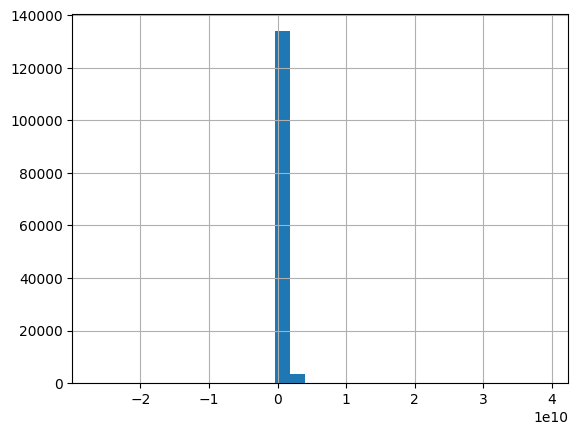

In [22]:
final_df.total_income.hist(bins=30)

In [23]:
from sklearn.ensemble import IsolationForest
columns_outlier = ['Insurance_expenses', 'Vehicle_purchase_expenses', 'total_income']
iso_forest = IsolationForest(contamination=0.1, random_state=42)
final_df['outlier']=iso_forest.fit_predict(final_df[columns_outlier])
# np.unique(final_df['outlier'], return_counts=True)

# Filter out the outliers
df_clean = final_df[final_df['outlier'] == 1]

# Drop the outlier column as it's no longer needed
df_clean = df_clean.drop(columns=['outlier'])

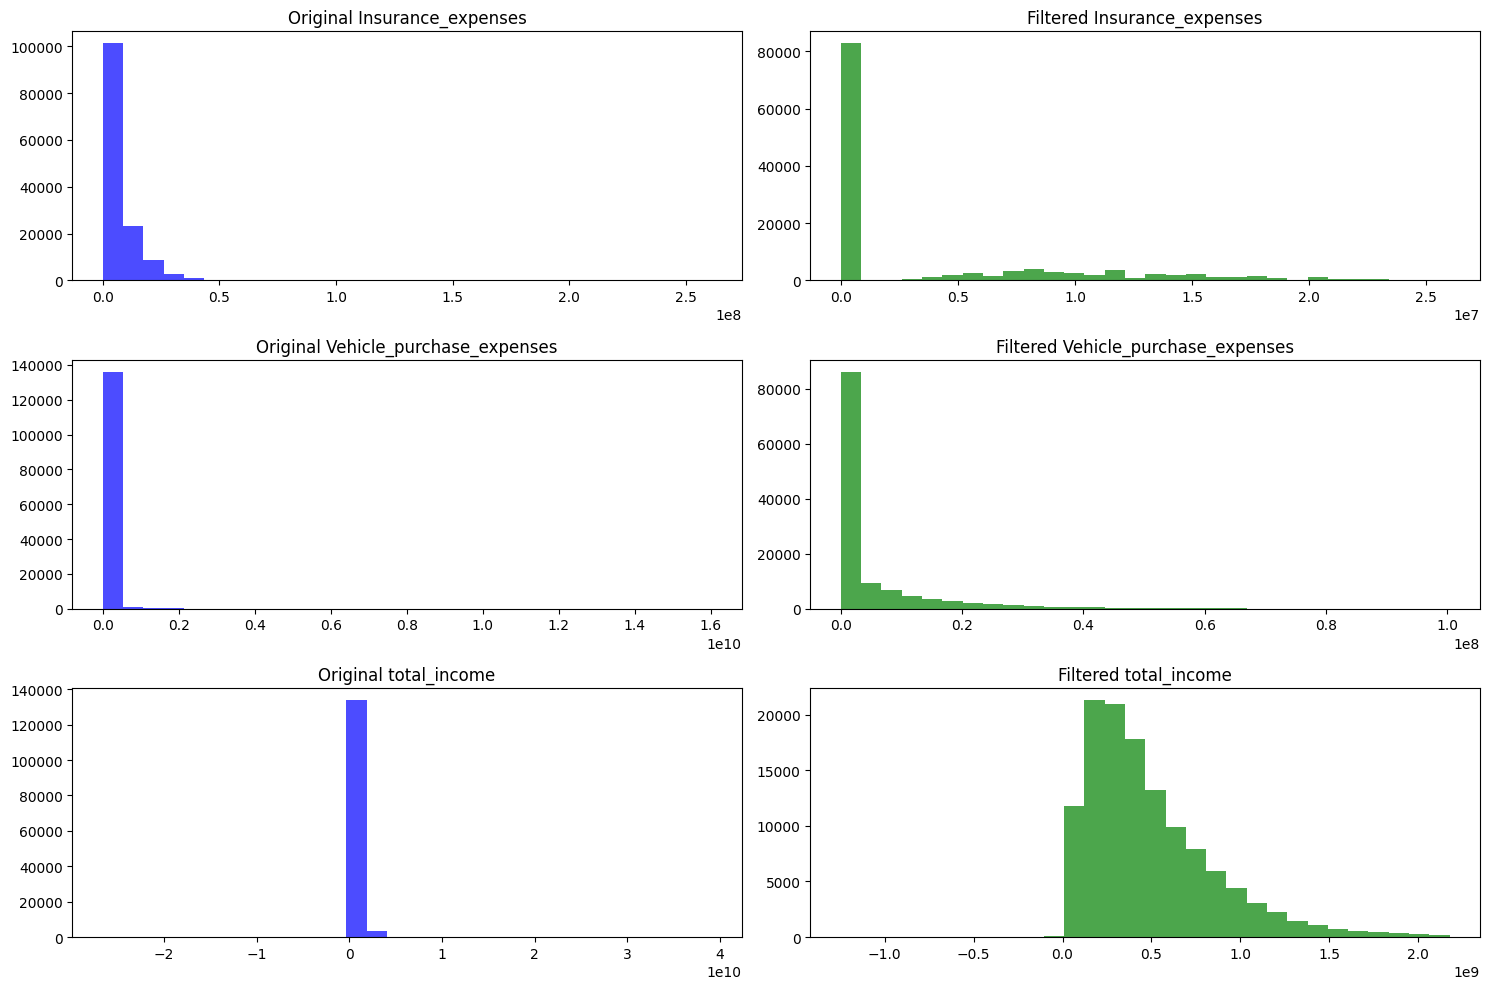

In [24]:
import matplotlib.pyplot as plt
# Plot histograms of the columns before and after removing outliers
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Original data
for i, column in enumerate(columns_outlier):
    axs[i, 0].hist(final_df[column], bins=30, color='blue', alpha=0.7)
    axs[i, 0].set_title(f'Original {column}')

    # Filtered data
    axs[i, 1].hist(df_clean[column], bins=30, color='green', alpha=0.7)
    axs[i, 1].set_title(f'Filtered {column}')

plt.tight_layout()
plt.show()

In [25]:
winter_of_1401 = (df_clean['Year'] == 1401) & (df_clean['Fasl'] == 4)
X_test = df_clean[winter_of_1401]
X_train = df_clean[~winter_of_1401]

y_test = X_test.pop("transportation_cost")
y_train = X_train.pop("transportation_cost")

In [26]:
X_train.head()

,Address,Fasl,Urban,Year,khanevartype,member_cnt,active_member_cnt,highly_educated_member_cnt,vehicle,motorcycle,...,province_Zanjan,tenure_Free,tenure_Mortgage,tenure_Other,tenure_OwnedEstate,tenure_OwnedEstateLand,tenure_Rent,tenure_Service,tenure_nan,total_income
1,20001383923,2,0,1400,0,4,3.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,636000000.0
2,20001383925,2,0,1400,0,4,1.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,232960000.0
3,20001383929,2,0,1400,0,2,1.0,0.0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190280000.0
4,20001383932,2,0,1400,0,2,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,427280000.0
5,20001383935,2,0,1400,0,4,2.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,343105000.0


In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
columns_standard = ['Insurance_expenses', 'Vehicle_purchase_expenses', 'total_income']

# Extract the columns to be standardized from the training and test sets
X_train_to_standardize = X_train_copy[columns_standard]
X_test_to_standardize = X_test_copy[columns_standard]

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_to_standardize)
X_test_scaled = scaler.transform(X_test_to_standardize)

# Convert the scaled data back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=columns_standard)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=columns_standard)

# Replace the original columns with the standardized columns in the training and test sets
X_train_copy[columns_standard] = X_train_scaled_df
X_test_copy[columns_standard] = X_test_scaled_df


In [30]:
X_train_copy.head()

,Address,Fasl,Urban,Year,khanevartype,member_cnt,active_member_cnt,highly_educated_member_cnt,vehicle,motorcycle,...,province_Zanjan,tenure_Free,tenure_Mortgage,tenure_Other,tenure_OwnedEstate,tenure_OwnedEstateLand,tenure_Rent,tenure_Service,tenure_nan,total_income
1,20001383923,2,0,1400,0,4,3.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.687346
2,20001383925,2,0,1400,0,4,1.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.812387
3,20001383929,2,0,1400,0,2,1.0,0.0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.118041
4,20001383932,2,0,1400,0,2,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.364651
5,20001383935,2,0,1400,0,4,2.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.537340


In [31]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [38]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_copy)
X_test_imputed = imputer.transform(X_test_copy)
column_names = X_train_copy.columns
X_train_imputed = pd.DataFrame(X_train_imputed, columns=column_names)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=column_names)

In [39]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [40]:
# Calculate VIF for the training set
vif_values = calculate_vif(X_train_imputed)
print("VIF values:")
print(vif_values)

c:\Users\sazgar\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF values:
                           Feature           VIF
0                          Address  1.124739e+06
1                             Fasl  1.021039e+00
2                            Urban  1.106821e+06
3                             Year  1.686203e+06
4                     khanevartype  1.003031e+00
5                       member_cnt  1.898467e+00
6                active_member_cnt  1.812126e+00
7       highly_educated_member_cnt  1.175524e+00
8                          vehicle  1.196591e+00
9                       motorcycle  1.205127e+00
10                         bicycle  1.065580e+00
11                 dining_expenses  1.009732e+00
12              Insurance_expenses  1.361805e+00
13       Vehicle_purchase_expenses  1.347182e+00
14                 province_Alborz  3.451034e+13
15                province_Ardebil  2.440975e+13
16       province_AzarbaijanGharbi  1.789628e+12
17      province_AzarbaijanSharghi  1.143046e+13
18               province_Boushehr  3.940157e+12
19     p

In [41]:
X_train_imputed.drop(columns=['Fasl', 'khanevartype', 'dining_expenses'], inplace=True)
X_test_imputed.drop(columns=['Fasl', 'khanevartype', 'dining_expenses'], inplace=True)

In [42]:
def train_ridge_model(X_train, y_train, alpha):
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(X_train, y_train)
    return ridge_reg

In [43]:
ridge_model = train_ridge_model(X_train_imputed, y_train, alpha=1.0)

# Evaluate the model on the test set
y_pred = ridge_model.predict(X_test_imputed)
mse = mean_squared_error(y_test, y_pred)
print(f"\nMean squared error on test set: {mse:.2f}")
r2 = r2_score(y_test, y_pred)
print(f"\nr2_score error on test set: {r2:.2f}")


Mean squared error on test set: 22350387228093.68

r2_score error on test set: 0.08


c:\Users\sazgar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.01877e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [44]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train_imputed, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [45]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [10, 15, 20, None],
#     'min_samples_split': [2, 5, 10]
# }
# param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# lasso = Lasso()
# lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
# lasso_cv.fit(X_train_imputed, y_train)
# best_lasso = lasso_cv.best_estimator_

# ridge = Ridge()
# ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
# ridge_cv.fit(X_train_imputed, y_train)
# best_ridge = ridge_cv.best_estimator_

In [46]:
# # Training and Predictions with Ridge
# y_train_pred_ridge = best_ridge.predict(X_train_imputed)
# y_test_pred_ridge = best_ridge.predict(X_test_imputed)

# # Training and Predictions with Lasso
# y_train_pred_lasso = best_lasso.predict(X_train_imputed)
# y_test_pred_lasso = best_lasso.predict(X_test_imputed)

# # Evaluate the models
# train_mse_ridge = mean_squared_error(y_train, y_train_pred_ridge)
# test_mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
# train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
# test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

# train_mse_lasso = mean_squared_error(y_train, y_train_pred_lasso)
# test_mse_lasso = mean_squared_error(y_test, y_test_pred_lasso)
# train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
# test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

# print("Ridge Regression")
# print(f"Train MSE: {train_mse_ridge}")
# print(f"Test MSE: {test_mse_ridge}")
# print(f"Train R2: {train_r2_ridge}")
# print(f"Test R2: {test_r2_ridge}")

# print("\nLasso Regression")
# print(f"Train MSE: {train_mse_lasso}")
# print(f"Test MSE: {test_mse_lasso}")
# print(f"Train R2: {train_r2_lasso}")
# print(f"Test R2: {test_r2_lasso}")

In [47]:
y_train_pred = model.predict(X_train_imputed)
y_test_pred = model.predict(X_test_imputed)

In [48]:
# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")

Train MSE: 891815225326.7339
Test MSE: 22444590236532.664
Train R2: 0.8731441052592436
Test R2: 0.07141126089806704
